In [92]:
import pandas as pd
# import oec
#import requests
import numpy as np
import zipfile
import os
import seaborn as sns
%matplotlib inline

In [2]:
### Use the following code to unzip and rename new zipfiles.
# full_demos_minus_cntlist = demo_df.loc[(~demo_df['Country'].isin(country_list)) & (demo_df['Regimetype']=='Full democracy'), 'Country'].values
def unzip_trade_data(cntlist, file_path, country_list=[]):
    """ 
    cntlist: list of new countries for which there are zipfiles to open. 
    file_path: either path_imp_data or path_exp_data
    country_list: list of current countries for which extended trade already exists, i.e. has been unzipped
    """
    for cnt in cntlist:
        with zipfile.ZipFile(file_path.format(cnt) + 'zip',"r") as zip_ref:
            zip_ref.extractall('\\'.join(path_exp_data.split('\\')[:-1]))
            os.rename(file_path.split('-')[0] + '-2018---Click-to-Select' + '.csv', file_path.format(cnt) + 'csv')
        if  cnt not in country_list:  
            country_list.append(cnt)
    return country_list

## Democracy Index Data

### We start out by retrieving some information about the democracy score for a range of countries. I actually spent quite a while trying to do this with Beautiful Soup, but eventually gave up and opted for pandas' builtin read_html function. (If anyone out there has a nice code snippet to do this with Beautilful Soup for wiki tables that also contain < li > elements then let me know, as I have other ideas for similar projects where this will be needed!)  

In [ ]:
democracy_rank = r'https://en.wikipedia.org/wiki/Democracy_Index'
demo_df = pd.read_html(democracy_rank, header=0)[2][:-1] # 

### Let's print out the first ten rows:

In [ ]:
demo_df.head(10)

### We observe that for Canada (and other countries) something is wrong. Studying the html one realizes that this is due to a row value (Rank=7) spanning two rows. It stems from the fact that Denmark and Canada are tied for seventh place. 
### Let's see how many others are affected by this

In [ ]:
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[:-1]]

### Next we will fix this. (We actully won't be using the rank directly, but still...) 

In [ ]:
tmp_df = demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[:-1]]
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), 'Rank'] = '-'
demo_df.loc[~demo_df.Rank.apply(lambda x: x.isdigit()), demo_df.columns.values[1:]] = tmp_df.values
demo_df.head(10)

### And we see that Canada (and the rest, though not shown) have been fixed. 
### Now we do away with the last column which we will not use, and make some minor fixes that are required to make the data on democracy scores be aligned with the trade data we will be loading in the following

In [3]:
demo_df.drop(demo_df.columns.values[-1], axis=1, inplace=True)
demo_df.loc[demo_df['Country']=='Eswatini', 'Country'] = 'Swaziland'
demo_df.loc[demo_df['Country']=='Taiwan', 'Country'] = 'Chinese Taipei'
demo_df.loc[demo_df['Country']=='Myanmar', 'Country'] = 'Burma'
demo_df.loc[demo_df['Country']=='South Korea[n 2]', 'Country'] = 'South Korea'
demo_df.loc[demo_df['Country'].str.contains('Ivory'), 'Country'] = 'Cote d\'Ivoire'
demo_df.loc[demo_df['Country'].str.contains('Cze'), 'Country'] = 'Czechia'
demo_df['Score'] = demo_df['Score'].astype(float)
demo_df.rename(columns={'Electoral processand pluralism': 'Electoral process and pluralism',
       'Functio­ning ofgovern­ment': 'Functioning of government', 'Politicalpartici­pation': 'Political participation',
       'Politicalculture': 'Political culture', 'Civilliberties': 'Civil liberties', 'Regimetype': 'Regime type', 'Region[n 1]': 'Region'},
              inplace=True)
demo_df.to_csv(os.getcwd() + r'\.Neo4jDesktop\demo_data.csv', index=False)

In [139]:
demo_df.loc[demo_df['Country'].str.contains('Gambia'), 'Country']

106    Gambia
Name: Country, dtype: object

### Let's take a look at the heads and tails of the demo data

In [ ]:
pd.concat([demo_df.head(), demo_df.tail()], axis=0)

### Let's do a quick groupby on region and look at the stats for the democracy score:

In [ ]:
demo_df.groupby('Region')['Score'].describe().reset_index()

### We can see that North America (which consists of just Canada and the US) has the highest average democracy score, while the Middle East & North Africa has the lowest. 

In [ ]:
pd.crosstab(demo_df['Region'], demo_df['Regime type']).reset_index()

In [ ]:
demo_df.groupby('Region')['Regime type'].value_counts()

### Next we get the Environmental Performance Index

In [4]:
epi_path = r'https://epi.yale.edu/epi-results/2020/component/epi'

In [5]:
epi_df = pd.read_html(epi_path)[0] #[2][:-1]

In [6]:
epi_df.head()

,Country,Rank,EPI Score,10-Year Change
0,Denmark,1,82.5,7.3
1,Luxembourg,2,82.3,11.6
2,Switzerland,3,81.5,8.6
3,United Kingdom,4,81.3,9
4,France,5,80.0,5.8


### Some of these we know to be in the democracy data under a different name. Let's change those names so they are aligned

In [7]:
epi_df.loc[epi_df['Country'].str.contains('Republic of'), 'Country'] = 'Republic of the Congo'
epi_df.loc[epi_df['Country'].str.contains('Dem.'), 'Country'] = 'Democratic Republic of the Congo'
epi_df.loc[epi_df['Country'].str.contains('Cze'), 'Country'] = 'Czechia'
epi_df.loc[epi_df['Country']=='Eswatini', 'Country'] = 'Swaziland'
epi_df.loc[epi_df['Country']=='Taiwan', 'Country'] = 'Chinese Taipei'
epi_df.loc[epi_df['Country']=='Myanmar', 'Country'] = 'Burma'
epi_df.loc[epi_df['Country']=='Viet Nam', 'Country'] = 'Vietnam'
epi_df.loc[epi_df['Country']=='Cabo Verde', 'Country'] = 'Cape Verde'
epi_df.loc[epi_df['Country']=='United States of America', 'Country'] = 'United States'
epi_df.loc[epi_df['Country']=='Brunei Darussalam', 'Country'] = 'Brunei'

In [8]:
epi_df.to_csv(os.getcwd() + r'\.Neo4jDesktop\epi_data.csv', index=False)

### Next get the Corruption Perceptions Index:

In [9]:
cpi_path = r'https://en.wikipedia.org/wiki/Corruption_Perceptions_Index'

In [10]:
cpi_df = pd.read_html(cpi_path, header=0)[4].loc[1:,['Rank', 'NationorTerritory', '2019[17]']]

In [11]:
cpi_df.rename(columns={'NationorTerritory': 'Country', '2019[17]': 'CPI Score'}, inplace=True)

### Change names to ensure alignment

In [12]:
cpi_df.loc[cpi_df['Country']=='DR Congo', 'Country'] = 'Democratic Republic of the Congo' 
cpi_df.loc[cpi_df['Country'].str.contains('Ivory'), 'Country'] = 'Cote d\'Ivoire'
cpi_df.loc[cpi_df['Country'].str.contains('Cze'), 'Country'] = 'Czechia'
cpi_df.loc[cpi_df['Country']=='Myanmar', 'Country'] = 'Burma'
cpi_df.loc[cpi_df['Country']=='Taiwan', 'Country'] = 'Chinese Taipei'
cpi_df.loc[cpi_df['Country']=='São Tomé and Príncipe', 'Country'] = 'Sao Tome and Principe'
cpi_df.loc[cpi_df['Country']=='East Timor', 'Country'] = 'Timor-Leste'

In [13]:
cpi_df.head()

,Rank,Country,CPI Score
1,1,New Zealand,87
2,1,Denmark,87
3,3,Finland,86
4,4,Singapore,85
5,4,Switzerland,85


In [14]:
cpi_df.to_csv(os.getcwd() + r'\.Neo4jDesktop\cpi_data.csv', index=False)

### Now we retrieve the Social Progress Index

In [73]:
spi_path = r'https://en.wikipedia.org/wiki/Social_Progress_Index'

In [74]:
cols = list(pd.read_html(spi_path, header=0)[1].loc[0,].values[:-1])

In [75]:
cols.insert(0, 'Country')

In [76]:
spi_df = pd.read_html(spi_path, header=0)[1].loc[1:,]

In [77]:
spi_df.rename(columns=dict(zip(spi_df.columns.values, cols)), inplace=True)
spi_df.rename(columns={'Score': 'SPI Score'}, inplace=True)

In [80]:
spi_df.loc[~spi_df['Country'].isin(demo_df.Country)]

,Country,Rank,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity
40,Barbados,40,77.89,89.35,76.78,67.55
97,Sao Tome and Principe,97,61.42,67.05,63.23,53.98
149,South Sudan,149,24.44,32.15,26.28,14.90
153,Brunei,NaN,NaN,NaN,78.17,NaN
161,Maldives,NaN,NaN,85.33,NaN,38.94
163,Seychelles,NaN,NaN,86.14,76.36,NaN
164,Solomon Islands,NaN,NaN,NaN,54.15,NaN
165,Somalia,NaN,NaN,37.72,NaN,NaN
168,Vanuatu,NaN,NaN,66.16,55.84,NaN


In [79]:
spi_df.loc[spi_df['Country']=='The Gambia', 'Country'] = 'Gambia'
spi_df.loc[spi_df['Country']=='Republic of North Macedonia', 'Country'] = 'North Macedonia'
spi_df.loc[spi_df['Country']=='Congo, Republic of', 'Country'] = 'Republic of the Congo'
spi_df.loc[spi_df['Country']=='Congo, Democratic Republic of', 'Country'] = 'Democratic Republic of the Congo'
spi_df.loc[spi_df['Country'].str.contains('Cze'), 'Country'] = 'Czechia'
spi_df.loc[spi_df['Country']=='Côte d\'Ivoire', 'Country'] = 'Cote d\'Ivoire'
spi_df.loc[spi_df['Country']=='Myanmar', 'Country'] = 'Burma'
spi_df.loc[spi_df['Country']=='Cabo Verde', 'Country'] = 'Cape Verde'
spi_df.loc[spi_df['Country']=='Brunei Darussalam', 'Country'] = 'Brunei'
spi_df.loc[spi_df['Country']=='São Tomé and Príncipe', 'Country'] = 'Sao Tome and Principe'


In [23]:
spi_df.loc[~spi_df['Country'].isin(epi_df.Country)]

,Country,Rank,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity
129,North Korea,129,46.95,63.39,50.12,27.34
149,South Sudan,149,24.44,32.15,26.28,14.9
160,Libya,NaN,NaN,72.38,NaN,38.06
165,Somalia,NaN,NaN,37.72,NaN,NaN


In [24]:
epi_df.loc[~epi_df['Country'].isin(spi_df.Country)]

,Country,Rank,EPI Score,10-Year Change
39,Chinese Taipei,40,57.2,4.6
58,Venezuela,59,50.3,-0.5
62,Antigua and Barbuda,63,48.5,3.3
63,Saint Vincent and the Grenadines,64,48.4,6.1
82,Tonga,82,45.1,2.4
85,Dominica,86,44.6,1.1
92,Bahamas,93,43.5,-2.4
94,Grenada,95,43.1,5.4
95,Saint Lucia,95,43.1,-1.4
100,Belize,101,41.9,-2


In [25]:
spi_df.loc[~spi_df['Country'].isin(cpi_df.Country)]

,Country,Rank,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity
58,Montenegro,58,71.16,84.95,76.88,51.66
91,Fiji,91,63.85,81.97,60.98,48.6
115,Swaziland,115,51.21,62.97,52.00,38.68
154,Equatorial Guinea,NaN,NaN,61.68,NaN,25.53
163,Seychelles,NaN,NaN,86.14,76.36,NaN
168,Vanuatu,NaN,NaN,66.16,55.84,NaN


In [26]:
cpi_df.loc[~cpi_df['Country'].isin(spi_df.Country)]

,Rank,Country,CPI Score
16,16,Hong Kong,76
27,28,Chinese Taipei,65
28,29,Bahamas,64
38,39,Saint Vincent and the Grenadines,59
47,48,Dominica,55
48,48,Saint Lucia,55
51,51,Grenada,53
101,101,Kosovo,36
169,173,Venezuela,16
172,176,Yemen,15


### In the next part, we load data on import/exports between a list of countries and all other countries. The list comprises all the countries that are deemed full democracies, except for Luxembourg, and then a few other countries that have been picked somewhat randomly plus all the authoritarian regimes.
### The data can be found at [oec](https://legacy.oec.world/en/), and there is an api. I just couldn't make it work based on the python libraries I could find, and seeing as I wanted to work with the interface between Python and Neo4j and not spend my time updating code from a github repo, I opted for the old fashioned, very time consuming, way of downloading csv files. Not very 2020, I know... 


In [27]:
# df = pd.DataFrame()
# for chunk in pd.read_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\year_origin_destination_hs07_4.tsv.bz2', compression='bz2', sep='\t', chunksize=4000000):
# #     chunk.iloc[0,], chunk.iloc[chunk.shape[0]-1,]
#     if chunk.iloc[0,].name>=44000000:
#         chunk.head()
#         df = pd.concat([df, chunk])
# #  delim_whitespace=True

In [28]:
# df = pd.read_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\year_origin_destination_hs07_4.tsv.bz2', compression='bz2', sep='\t', skiprows=43999999)

In [156]:
path_cnt_data = r'C:\Users\GU216ZX\.Neo4jDesktop\eci_hs6_hs96_98-18.csv'
path_imp_data = r'C:\Users\GU216ZX\.Neo4jDesktop\Origins-2018 - {}.'
path_exp_data = r'C:\Users\GU216ZX\.Neo4jDesktop\Destinations-2018 - {}.'

country_list = ['Denmark',
                'Sweden',
                'Germany',
                'Norway',
                'North Korea',
                'China',
                'Russia',
                'South Korea',
                'Mexico',
                'United States',
                'India',
                'Nigeria',
                'Brazil',
                'Japan',
                'Iceland',
                'New Zealand',
                'Finland',
                'Ireland',
                'Canada',
                'Australia',
                'Switzerland',
                'Netherlands',
                'United Kingdom',
                'Uruguay',
                'Austria',
                'Spain',
                'Mauritius',
                'Costa Rica',
                'France',
                'Chile',
                'Portugal', 'Chad', 'Democratic Republic of the Congo', 
         'Central African Republic', 'Syria', 
         'Turkmenistan', 'Equatorial Guinea', 
         'Tajikistan', 'Saudi Arabia', 
         'Yemen', 'Uzbekistan', 
         'Libya', 'Laos', 
         'Burundi', 'Iran', 
         'Belarus', 'Bahrain', 
         'Guinea-Bissau', 'Sudan', 
        'United Arab Emirates', 'Djibouti',
        'Cuba', 'Cameroon', 'Afghanistan', 
         'Kazakhstan', 'Oman', 'Egypt', 'Vietnam', 
         'Republic of the Congo', 'Guinea', 
         'Comoros', 'Zimbabwe', 
         'Rwanda', 'Qatar', 
         'Niger', 'Togo', 'Ethiopia', 'Cambodia', 
         'Nicaragua', 'Burma', 'Gabon', 'Mozambique', 'Angola', 'Iraq', 'Palestine', 
                'Mauritania', 'Kuwait', 'Jordan', 'Malta', 'Estonia',
       'Israel', 'Cape Verde', 'Chinese Taipei', 'Czechia',
       'Cyprus', 'Italy', 'Slovenia', 'Lithuania', 'Latvia',
       'Greece', 'South Africa', 'Timor-Leste', 'Slovakia', 'Malaysia',
       'Trinidad and Tobago', 'Colombia', 'Panama', 'Bulgaria',
       'Argentina', 'Suriname', 'Jamaica', 'Tunisia',
       'Philippines', 'Ghana', 'Hungary', 'Poland', 'Peru', 'Croatia',
       'Dominican Republic', 'Mongolia', 'Romania',
       'Indonesia', 'Serbia', 'Ecuador', 'Thailand',
       'Sri Lanka', 'Paraguay', 'El Salvador', 'Guyana',
       'Papua New Guinea', 'Hong Kong', 'Singapore', 'North Macedonia', 'Ukraine', 'Albania', 'Bangladesh', 'Fiji',
       'Senegal', 'Moldova', 'Montenegro', 'Madagascar', 'Armenia',
       'Malawi', 'Liberia', 'Georgia', 'Honduras', 'Bhutan', 'Nepal',
       'Guatemala', 'Kenya', 'Tanzania', 'Morocco', 'Benin', 'Zambia',
       'Uganda', 'Mali', 'Kyrgyzstan', 'Bosnia and Herzegovina',
       'Sierra Leone', 'Bolivia', 'Haiti', 'Lebanon', 'Gambia',
       'Pakistan', 'Turkey', "Cote d'Ivoire", 'Burkina Faso',
       'Algeria', 'Eritrea', 'Venezuela', 'Azerbaijan']

# len(country_list)
country_df = pd.DataFrame(columns=['Country'], data=country_list)
## Only run this if you have new country data you want to unzip
# clist = ['Eritrea', 'Venezuela', 'Azerbaijan']
# unzip_trade_data(clist, path_exp_data)

In [158]:
country_df.to_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\country_list.csv', index=False)

### First we retrieve information on the complexity of doing business in a given country for 2018...

In [81]:
df_cnt = pd.read_csv(path_cnt_data)
df_cnt = df_cnt[['2018', 'Country ID', 'Country']]
df_cnt.fillna(-99999,inplace=True)
df_cnt = df_cnt.sort_values('2018', ascending=False).reset_index(drop=True)
df_cnt.rename(columns={'2018': 'Complexity Index'}, inplace=True)

### ... then we run through that nice long list of countries, load their trade data and merge it into the existing dataframe with the complexity index. We do an outer merge, as some countries for which there is trade data and a democracy score may not have had a complexity value assigned to them. 

In [82]:
for cnt in country_list:
#     df_imp = pd.read_csv(path_imp_data.format(cnt) + 'csv')
    df_exp = pd.read_csv(path_exp_data.format(cnt) + 'csv')
#     df_imp.rename(columns={'Trade Value': 'Import_Value'}, inplace=True)
    df_exp.rename(columns={'Trade Value': 'Export_Value'}, inplace=True)
#     df_cnt = df_cnt.merge(df_imp[['Country', 'Import_Value']], on='Country', how='outer')
    df_cnt = df_cnt.merge(df_exp[['Country', 'Export_Value']], on='Country', how='outer')
    df_cnt['Export_Value'].fillna(0, inplace=True)
#     df_cnt['Import_Value'].fillna(0, inplace=True)
#     df_cnt['Export_Balance_' + cnt] = df_cnt['Export_Value'] - df_cnt['Import_Value']
    df_cnt.rename(columns={'Export_Value': 'Export_Value_' + cnt}, inplace=True)
#     df_cnt.rename(columns={'Import_Value': 'Import_Value_' + cnt}, inplace=True)
df_cnt['Complexity Index'].fillna(-99999, inplace=True)

In [51]:
df_cnt.head()

,Complexity Index,Country ID,Country,Export_Value_Denmark,Export_Value_Sweden,Export_Value_Germany,Export_Value_Norway,Export_Value_North Korea,Export_Value_China,Export_Value_Russia,...,Export_Value_Lebanon,Export_Value_Gambia,Export_Value_Pakistan,Export_Value_Turkey,Export_Value_Cote d'Ivoire,Export_Value_Burkina Faso,Export_Value_Algeria,Export_Value_Eritrea,Export_Value_Venezuela,Export_Value_Azerbaijan
0,2.173286,asjpn,Japan,2.060595e+09,2.633925e+09,2.425291e+10,1.672701e+09,0.000000e+00,1.554709e+11,1.270942e+10,...,8.422701e+06,5.002069e+04,3.361452e+08,5.341573e+08,1.275594e+07,3.783713e+07,1.462824e+08,2.587700e+04,2.480051e+07,9.996837e+06
1,2.011652,euche,Switzerland,8.473726e+08,1.791278e+09,6.218620e+10,4.431430e+08,0.000000e+00,1.277119e+10,3.944407e+09,...,1.718435e+08,7.321117e+03,1.617152e+08,2.111164e+09,4.631263e+08,3.208363e+09,3.856103e+07,9.262129e+04,3.350937e+06,1.508109e+08
2,1.943747,asxxb,Chinese Taipei,3.456997e+08,6.087455e+08,9.469532e+09,2.578771e+08,0.000000e+00,4.945662e+10,4.629470e+09,...,4.899936e+06,1.347416e+06,1.776768e+08,3.154071e+08,2.885272e+05,4.724979e+05,2.667350e+08,7.152510e+04,8.588143e+06,7.300059e+08
3,1.895182,eudeu,Germany,1.548247e+10,1.740686e+10,0.000000e+00,2.022583e+10,2.447793e+06,9.692203e+10,2.329770e+10,...,4.826013e+07,5.257086e+05,1.783753e+09,1.663348e+10,7.832781e+08,6.592514e+07,6.830891e+08,8.302400e+04,3.253036e+08,8.203495e+08
4,1.851151,askor,South Korea,8.410242e+08,1.730338e+09,2.039064e+10,1.472063e+09,0.000000e+00,1.072203e+11,1.791128e+10,...,5.414521e+07,9.871033e+06,3.684384e+08,9.759374e+08,2.959678e+06,4.010430e+05,1.735836e+09,5.013147e+07,3.086902e+07,1.646382e+06


In [52]:
df_cnt.shape
# df_cnt.loc[df_cnt['Country']=='Denmark']

(221, 164)

### In the following cell we add the information on regime type, democracy score and region to the dataframe containing the information on trade. 

In [83]:
df_cnt = df_cnt.merge(demo_df[['Country', 'Score', 'Regime type', 'Region']], on='Country', how='left')

In [84]:
df_cnt = df_cnt.merge(cpi_df[['Country', 'CPI Score']], on='Country', how='left')
df_cnt = df_cnt.merge(epi_df[['Country', 'EPI Score']], on='Country', how='left')

In [55]:
df_cnt.head()

,Complexity Index,Country ID,Country,Export_Value_Denmark,Export_Value_Sweden,Export_Value_Germany,Export_Value_Norway,Export_Value_North Korea,Export_Value_China,Export_Value_Russia,...,Export_Value_Burkina Faso,Export_Value_Algeria,Export_Value_Eritrea,Export_Value_Venezuela,Export_Value_Azerbaijan,Score,Regime type,Region,CPI Score,EPI Score
0,2.173286,asjpn,Japan,2.060595e+09,2.633925e+09,2.425291e+10,1.672701e+09,0.000000e+00,1.554709e+11,1.270942e+10,...,3.783713e+07,1.462824e+08,2.587700e+04,2.480051e+07,9.996837e+06,7.99,Flawed democracy,Asia & Australasia,73,75.1
1,2.011652,euche,Switzerland,8.473726e+08,1.791278e+09,6.218620e+10,4.431430e+08,0.000000e+00,1.277119e+10,3.944407e+09,...,3.208363e+09,3.856103e+07,9.262129e+04,3.350937e+06,1.508109e+08,9.03,Full democracy,Western Europe,85,81.5
2,1.943747,asxxb,Chinese Taipei,3.456997e+08,6.087455e+08,9.469532e+09,2.578771e+08,0.000000e+00,4.945662e+10,4.629470e+09,...,4.724979e+05,2.667350e+08,7.152510e+04,8.588143e+06,7.300059e+08,7.73,Flawed democracy,Asia & Australasia,65,57.2
3,1.895182,eudeu,Germany,1.548247e+10,1.740686e+10,0.000000e+00,2.022583e+10,2.447793e+06,9.692203e+10,2.329770e+10,...,6.592514e+07,6.830891e+08,8.302400e+04,3.253036e+08,8.203495e+08,8.68,Full democracy,Western Europe,80,77.2
4,1.851151,askor,South Korea,8.410242e+08,1.730338e+09,2.039064e+10,1.472063e+09,0.000000e+00,1.072203e+11,1.791128e+10,...,4.010430e+05,1.735836e+09,5.013147e+07,3.086902e+07,1.646382e+06,8.00,Flawed democracy,Asia & Australasia,59,66.5


In [85]:
df_cnt[['Regime type', 'Region']] = df_cnt[['Regime type', 'Region']].fillna('Unknown')

In [86]:
for k in df_cnt.columns[df_cnt.columns.str.contains('Export')].values:
    df_cnt[k] = df_cnt[k].fillna(0) 

In [87]:
df_cnt['CPI Score'] = df_cnt['CPI Score'].astype(float)

In [88]:
df_cnt = df_cnt.merge(spi_df[['Country', 'SPI Score', 'Basic Human Needs', 'Foundation of Well Being', 'Opportunity']], on='Country', how='left')

In [90]:
df_cnt[['SPI Score', 'Basic Human Needs', 'Foundation of Well Being', 'Opportunity']] = df_cnt[['SPI Score', 'Basic Human Needs', 'Foundation of Well Being', 'Opportunity']].astype(float)

### Here we gather some more data on memberships to different supra national organizations

In [129]:
wto_path = r'https://en.wikipedia.org/wiki/Member_states_of_the_World_Trade_Organization'
wto_df = pd.read_html(wto_path, header=0)[0]
wto_df.rename(columns={'State[15][28][17]': 'Country'}, inplace=True)

In [130]:
wto_df.shape

(164, 3)

### Remove references from country names

In [131]:
wto_df['Country'] = wto_df['Country'].str.replace('(\[[a-z]\])','', regex=True)

### Clean up country names

In [137]:
wto_df[~wto_df['Country'].isin(df_cnt.Country)]

,Country,Date of accession,GATT membership
11,Belgium,1 January 1995,1 January 1948
15,Botswana,31 May 1995,28 August 1987
47,Eswatini,1 January 1995,8 February 1993
48,European Union,1 January 1995,NaN
83,Lesotho,31 May 1995,8 January 1988
85,Liechtenstein,1 September 1995,29 March 1994
87,Luxembourg,1 January 1995,1 January 1948
104,Namibia,1 January 1995,15 September 1992


In [136]:
wto_df.loc[wto_df['Country'].str.contains('Czec'), 'Country'] = 'Czechia'
wto_df.loc[wto_df['Country']=='Côte d\'Ivoire', 'Country'] = 'Cote d\'Ivoire'
wto_df.loc[wto_df['Country']=='Taiwan', 'Country'] = 'Chinese Taipei'
wto_df.loc[wto_df['Country']=='Myanmar', 'Country'] = 'Burma'
wto_df.loc[wto_df['Country']=='People\'s Republic of China', 'Country'] = 'China'

In [142]:
df_cnt['WTO_Member'] = 0
df_cnt.loc[df_cnt['Country'].isin(wto_df['Country']), 'WTO_Member'] = 1

In [144]:
df_cnt.head()

,Complexity Index,Country ID,Country,Export_Value_Denmark,Export_Value_Sweden,Export_Value_Germany,Export_Value_Norway,Export_Value_North Korea,Export_Value_China,Export_Value_Russia,...,Score,Regime type,Region,CPI Score,EPI Score,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity,WTO_Member
0,2.173286,asjpn,Japan,2.060595e+09,2.633925e+09,2.425291e+10,1.672701e+09,0.000000e+00,1.554709e+11,1.270942e+10,...,7.99,Flawed democracy,Asia & Australasia,73.0,75.1,88.34,97.72,91.04,76.26,1
1,2.011652,euche,Switzerland,8.473726e+08,1.791278e+09,6.218620e+10,4.431430e+08,0.000000e+00,1.277119e+10,3.944407e+09,...,9.03,Full democracy,Western Europe,85.0,81.5,89.89,96.98,91.14,81.55,1
2,1.943747,asxxb,Chinese Taipei,3.456997e+08,6.087455e+08,9.469532e+09,2.578771e+08,0.000000e+00,4.945662e+10,4.629470e+09,...,7.73,Flawed democracy,Asia & Australasia,65.0,57.2,NaN,NaN,NaN,NaN,1
3,1.895182,eudeu,Germany,1.548247e+10,1.740686e+10,0.000000e+00,2.022583e+10,2.447793e+06,9.692203e+10,2.329770e+10,...,8.68,Full democracy,Western Europe,80.0,77.2,88.84,95.75,87.70,83.06,1
4,1.851151,askor,South Korea,8.410242e+08,1.730338e+09,2.039064e+10,1.472063e+09,0.000000e+00,1.072203e+11,1.791128e+10,...,8.00,Flawed democracy,Asia & Australasia,59.0,66.5,85.61,96.87,86.08,73.90,1


### Save the final dataframe 

In [145]:
df_cnt.to_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\demo_and_trade_data.csv', index=False)

In [91]:
df_cnt.head()

,Complexity Index,Country ID,Country,Export_Value_Denmark,Export_Value_Sweden,Export_Value_Germany,Export_Value_Norway,Export_Value_North Korea,Export_Value_China,Export_Value_Russia,...,Export_Value_Azerbaijan,Score,Regime type,Region,CPI Score,EPI Score,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity
0,2.173286,asjpn,Japan,2.060595e+09,2.633925e+09,2.425291e+10,1.672701e+09,0.000000e+00,1.554709e+11,1.270942e+10,...,9.996837e+06,7.99,Flawed democracy,Asia & Australasia,73.0,75.1,88.34,97.72,91.04,76.26
1,2.011652,euche,Switzerland,8.473726e+08,1.791278e+09,6.218620e+10,4.431430e+08,0.000000e+00,1.277119e+10,3.944407e+09,...,1.508109e+08,9.03,Full democracy,Western Europe,85.0,81.5,89.89,96.98,91.14,81.55
2,1.943747,asxxb,Chinese Taipei,3.456997e+08,6.087455e+08,9.469532e+09,2.578771e+08,0.000000e+00,4.945662e+10,4.629470e+09,...,7.300059e+08,7.73,Flawed democracy,Asia & Australasia,65.0,57.2,NaN,NaN,NaN,NaN
3,1.895182,eudeu,Germany,1.548247e+10,1.740686e+10,0.000000e+00,2.022583e+10,2.447793e+06,9.692203e+10,2.329770e+10,...,8.203495e+08,8.68,Full democracy,Western Europe,80.0,77.2,88.84,95.75,87.70,83.06
4,1.851151,askor,South Korea,8.410242e+08,1.730338e+09,2.039064e+10,1.472063e+09,0.000000e+00,1.072203e+11,1.791128e+10,...,1.646382e+06,8.00,Flawed democracy,Asia & Australasia,59.0,66.5,85.61,96.87,86.08,73.90


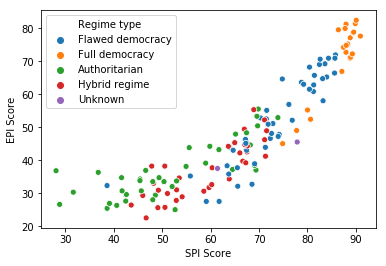

In [101]:
sns.scatterplot(x='SPI Score', y='EPI Score', data=df_cnt, hue='Regime type')

In [154]:
df_cnt.groupby('Regime type')[['EPI Score', 'SPI Score', 'CPI Score', 'Score']].describe().T

Regime type      Authoritarian  Flawed democracy  Full democracy  \
EPI Score count      48.000000         49.000000       21.000000   
          mean       38.035417         52.720408       71.347619   
          std         8.605948         13.149461       11.204491   
          min        25.100000         27.600000       45.100000   
          25%        30.800000         44.000000       71.000000   
          50%        36.950000         52.200000       74.900000   
          75%        44.400000         64.700000       78.900000   
          max        55.600000         75.100000       82.500000   
SPI Score count      40.000000         47.000000       21.000000   
          mean       52.139250         73.497234       86.675714   
          std        12.484364          9.614703        4.395956   
          min        28.050000         38.590000       74.880000   
          25%        42.547500         67.355000       87.120000   
          50%        49.850000         72.870000       88.020000   
          75%        64.097500         81.370000       89.290000   
          max        73.900000         88.340000       90.950000   
CPI Score count      51.000000         50.000000       21.000000   
          mean       30.372549         47.460000       75.000000   
          std        13.146803         13.480462       10.329569   
          min        13.000000         28.000000       52.000000   
          25%        20.000000         38.000000       69.000000   
          50%        26.000000         44.000000       77.000000   
          75%        37.000000         57.500000       84.000000   
          max        71.000000         85.000000       87.000000   
Score     count      53.000000         50.000000       21.000000   
          mean        2.766415          6.963800        8.804762   
          std         0.760195          0.608497        0.565284   
          min         1.080000          6.020000        8.030000   
          25%         2.150000          6.492500        8.290000   
          50%         2.850000          6.970000        9.010000   
          75%         3.290000          7.497500        9.240000   
          max         3.930000          8.000000        9.870000   

Regime type      Hybrid regime    Unknown  
EPI Score count      37.000000  19.000000  
          mean       37.032432  41.284211  
          std         8.298763   8.322677  
          min        22.600000  26.700000  
          25%        30.700000  36.450000  
          50%        35.600000  43.100000  
          75%        44.300000  45.350000  
          max        55.400000  58.200000  
SPI Score count      33.000000   3.000000  
          mean       59.110000  54.583333  
          std         8.957706  27.372991  
          min        43.580000  24.440000  
          25%        50.560000  42.930000  
          50%        60.230000  61.420000  
          75%        67.060000  69.655000  
          max        71.570000  77.890000  
CPI Score count      35.000000  12.000000  
          mean       34.171429  45.500000  
          std         9.153867  19.028686  
          min        18.000000   9.000000  
          25%        28.000000  38.750000  
          50%        33.000000  54.000000  
          75%        37.000000  59.250000  
          max        68.000000  64.000000  
Score     count      37.000000   0.000000  
          mean        5.090270        NaN  
          std         0.607876        NaN  
          min         4.010000        NaN  
          25%         4.840000        NaN  
          50%         5.160000        NaN  
          75%         5.540000        NaN  
          max         5.970000        NaN

LinAlgError: singular matrix

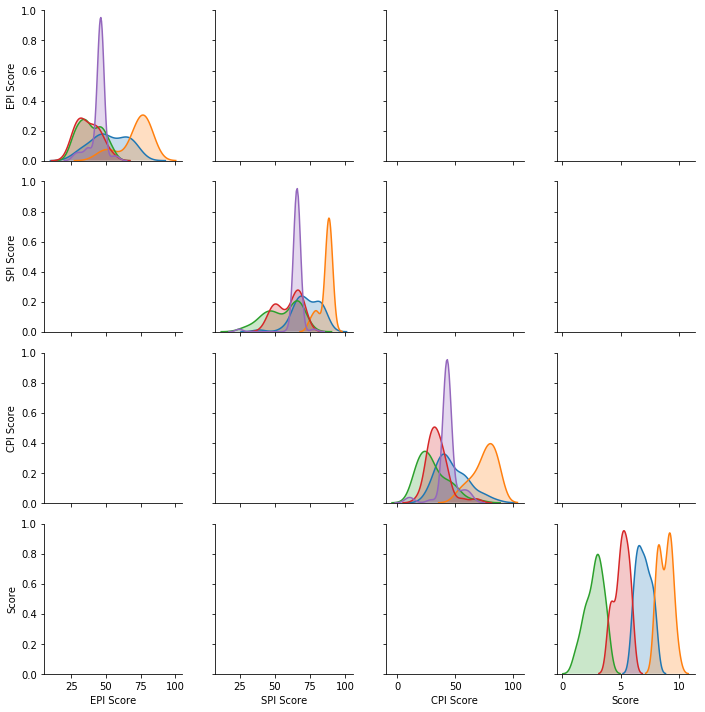

In [152]:
sns.pairplot(df_cnt[['EPI Score', 'SPI Score', 'CPI Score', 'Score','Regime type']].fillna(df_cnt[['EPI Score', 'SPI Score', 'CPI Score', 'Score']].mean()), hue='Regime type')